<a href="https://colab.research.google.com/github/stazam/Datamining2-project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files 

uploaded = files.upload()

Saving sciencetech_articles.npy to sciencetech_articles.npy
Saving sport_articles.npy to sport_articles.npy
Saving travel_articles.npy to travel_articles.npy


In [2]:
import numpy as np 

science = np.load('sciencetech_articles.npy',allow_pickle='TRUE').item()
sport = np.load('sport_articles.npy',allow_pickle='TRUE').item()
travel = np.load('travel_articles.npy',allow_pickle='TRUE').item()

odstanit prazdne stringy a url adresy spojit do jedneho stringu 



In [3]:
def preprocess_articles(articles) -> list:

  articles_preprocess = []

  for key,value in articles.items():
    list_temp = []
    list_temp.append(key)
    for text in value:
      if len(text) > 0:
        list_temp.append(text.lower().strip().rstrip())
    articles_preprocess.append(list_temp)

  articles_preprocess = [' '.join(item) for item in articles_preprocess]

  return articles_preprocess 

In [4]:
sport = preprocess_articles(sport)
labels_sport = [0] * len(sport)

travel = preprocess_articles(travel)
labels_travel = [1] * len(travel)

science = preprocess_articles(science)
labels_science = [2] * len(science)

articles = sport + travel + science
labels =  labels_sport + labels_travel + labels_science

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(articles, labels, test_size=0.33, random_state=42)


In [6]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
max_length = 10000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
vocab_size = 10700

In [8]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = np.array(pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = np.array(pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type))

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [10]:
import keras
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling1D, Flatten, Dropout
from keras import optimizers

In [11]:
model = Sequential([
    Embedding(vocab_size, 512, input_length=max_length),
    Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
    Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 5
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))

Epoch 1/5
6/6 [==============================] - 64s 9s/step - loss: 3.5035 - accuracy: 0.3512 - val_loss: 1.9910 - val_accuracy: 0.4096
Epoch 2/5
6/6 [==============================] - 47s 8s/step - loss: 1.5903 - accuracy: 0.3690 - val_loss: 1.1298 - val_accuracy: 0.4096
Epoch 3/5
6/6 [==============================] - 47s 8s/step - loss: 1.1569 - accuracy: 0.3512 - val_loss: 1.0675 - val_accuracy: 0.4096
Epoch 4/5
6/6 [==============================] - 47s 8s/step - loss: 1.1040 - accuracy: 0.3750 - val_loss: 1.0590 - val_accuracy: 0.4217
Epoch 5/5
6/6 [==============================] - 47s 8s/step - loss: 1.1636 - accuracy: 0.3988 - val_loss: 1.0485 - val_accuracy: 0.4096


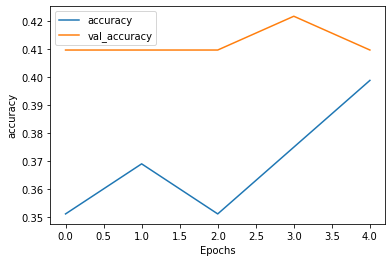

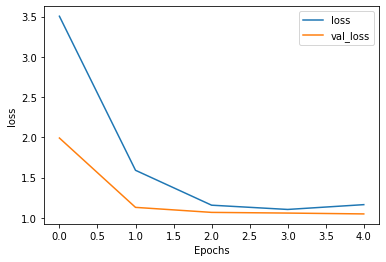

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
sentence = ["I am sport article about football game"]

In [21]:
sentence

['I am sport article about football game']

In [22]:
sequences = tokenizer.texts_to_sequences(sentence)
sequences

[[57, 999, 1947, 1, 69, 1581, 278]]

In [23]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.2043063  0.32733056 0.4683632 ]]


In [3]:
data = [[0.2043063, 0.32733056, 0.4683632 ]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


Text(0.5, 1.0, 'Results')

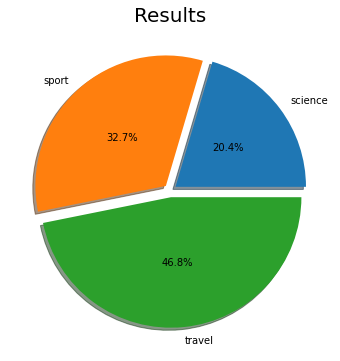

In [13]:
import matplotlib.pyplot as plt

pie, ax = plt.subplots(figsize=[10,6])
labels = ['science','sport','travel']
plt.pie(x=data[0:3], autopct="%.1f%%", explode=[0.05]*3, labels=labels, pctdistance=0.5, shadow=True)
plt.title("Results", fontsize=20)

In [ ]:
from tensorflow.keras.models import load_model

model.save('gfgModel.h5')
print('Model Saved!')
 
# load model
savedModel=load_model('gfgModel.h5')
savedModel.summary()

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)